**Setup**

In [ ]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

**Downloading the dataset**

Here we download NYU-v2 data set. This may take about 2 mins!

In [ ]:
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "nyu_depth_v2_labeled.mat",
        cache_subdir=os.path.abspath("."),
        origin="http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat",
        extract=True,
    )

2972049408/2972037809 [==============================] - 103s 0us/step


**Preparing the data**

We resize the data matrices to feed to the network for training

In [ ]:
import numpy as np
import h5py
f = h5py.File('/content/nyu_depth_v2_labeled.mat','r')
images = f.get('images')
images = np.array(images) # For converting to a NumPy array
imagess= np.transpose(images, (0,3,2,1))
depths = f.get('depths')
depths = np.array(depths) # For converting to a NumPy array
depthss= np.transpose(depths, (0,2,1))
depths= np.reshape(depthss, (1449,480,-1,1))

**Normalizing input data**

Our experiments showed that normalizing the depth data yields better results. Furthermore, normalizing the input RGB images is a must!

In [ ]:
m= depths.max(1)
n= m.max(1)
max_dep= n.max(1)
for i in range(len(max_dep)):
  depths[i,:,:,:]= depths[i,:,:,:]/max_dep[i]
# Due to the RAM limitations we could only use 200 instances of images. 
images= imagess[0:200,:,:,:]/255
print(images.shape)
print(depths.shape)

(200, 480, 640, 3)
(1449, 480, 640, 1)


**Visulizing input data**

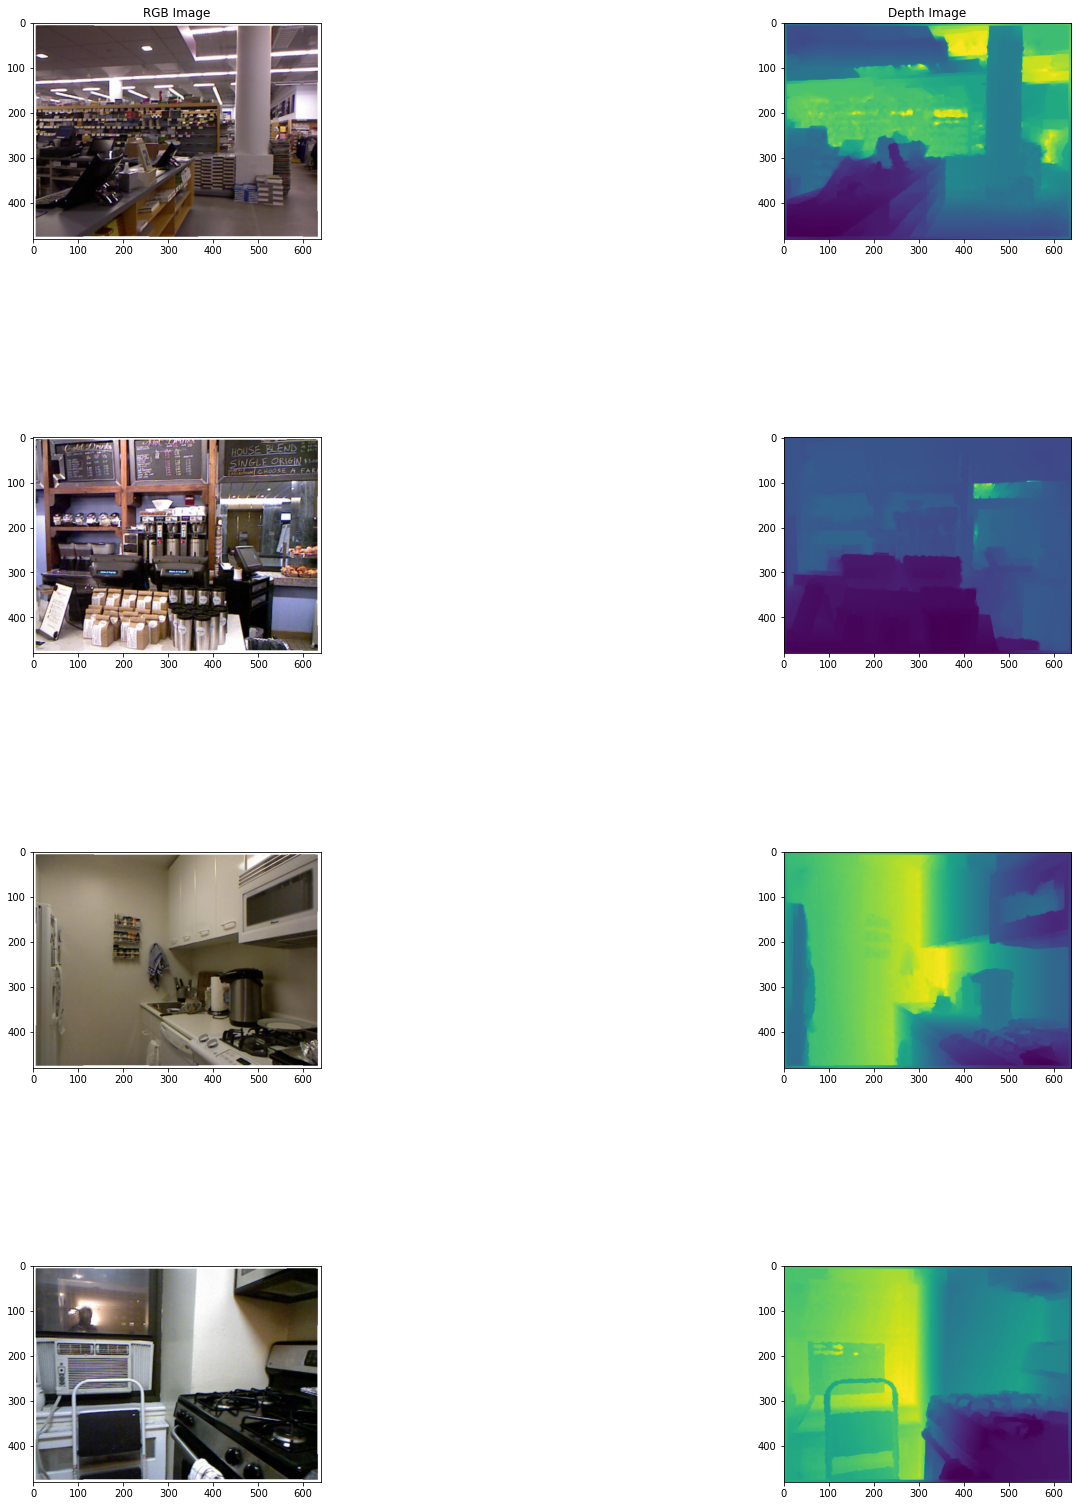

In [ ]:
fig, axs = plt.subplots(4, 2)

axs[0, 0].imshow(images[110,:,:,:])
axs[0, 1].imshow(depths[110,:,:,0])
axs[1, 0].imshow(images[120,:,:,:])
axs[1, 1].imshow(depths[120,:,:,0])
axs[2, 0].imshow(images[130,:,:,:])
axs[2, 1].imshow(depths[130,:,:,0])
axs[3, 0].imshow(images[140,:,:,:])
axs[3, 1].imshow(depths[140,:,:,0])

axs[0, 0].set_title("RGB Image")
axs[0, 1].set_title("Depth Image")

fig.tight_layout()
fig.set_size_inches(25, 25)

**Preparing hyperparameters**

In [ ]:
HEIGHT = 480
WIDTH = 640
LR = 0.0005
EPOCHS = 30
BATCH_SIZE = 32

**Building the model**

1. The basic model is from U-Net.
2. Addditive skip-connections are implemented in the downscaling block.

In [ ]:

class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


**Defining the loss**

We will optimize 3 losses in our mode.
1. Structural similarity index(SSIM).
2. L1-loss, or Point-wise depth in our case.
3. Depth smoothness loss.

Out of the three loss functions, SSIM contributes the most to improving model performance.

In [ ]:

class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.9
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 1
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="relu")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


## Model training

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)
model.fit(images, depths, batch_size = 6, epochs=6, validation_split=0.15, shuffle=True)
tf.keras.utils.plot_model(model, "depth_estimation.png", show_shapes=True)
model.summary()

Epoch 1/6
29/29 [==============================] - 32s 491ms/step - loss: 0.3717 - val_loss: 0.7832
Epoch 2/6
29/29 [==============================] - 10s 353ms/step - loss: 0.2108 - val_loss: 0.7341
Epoch 3/6
29/29 [==============================] - 10s 357ms/step - loss: 0.1694 - val_loss: 0.2016
Epoch 4/6
29/29 [==============================] - 10s 359ms/step - loss: 0.1495 - val_loss: 0.1523
Epoch 5/6
29/29 [==============================] - 10s 359ms/step - loss: 0.1358 - val_loss: 0.1101
Epoch 6/6
29/29 [==============================] - 11s 363ms/step - loss: 0.1349 - val_loss: 0.1045
Model: "depth_estimation_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 downscale_block (DownscaleB  multiple                 2896      
 lock)                                                           
                                                                 
 downscale_block_1 (Downscal  multiple

## Visualizing model output

We visualize the model output over the validation set.
The first image is the RGB image, the second image is the ground truth depth map image
and the third one is the predicted depth map image.

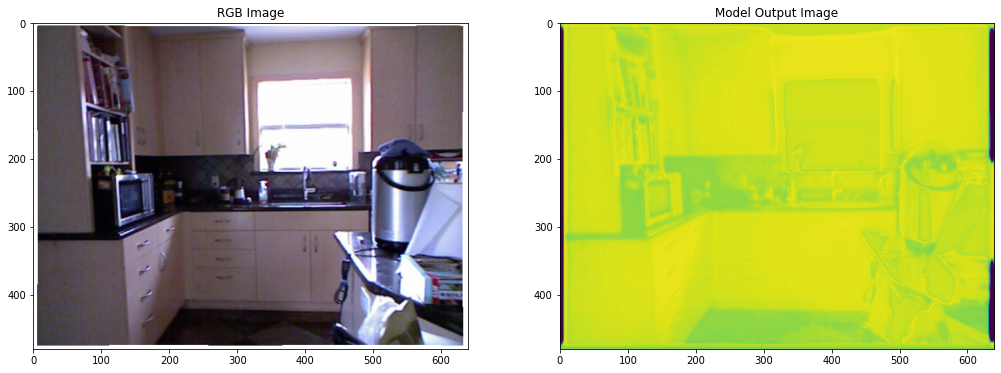

In [ ]:
im_test= imagess[816:817,:,:,:]/255
im_pred = model.predict(im_test)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(im_test[0,:,:,:])
axs[1].imshow(im_pred[0,:,:,0])

axs[0].set_title("RGB Image")
axs[1].set_title("Model Output Image")

fig.tight_layout()
fig.set_size_inches(15, 15)

## Possible improvements

1. You can improve this model by replacing the encoding part of the U-Net with a
pretrained DenseNet or ResNet.
2. Loss functions play an important role in solving this problem.
Tuning the loss functions may yield significant improvement.